## Data Preprocess

In [1]:
%load_ext autoreload
%autoreload 2
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '9'
from deepsramp import *

In [4]:
from joblib import Parallel, delayed
import random

def task_transform(name, position=0):
    idf = df
    indf = ndf
    
    tdf = []
    for _, i in tqdm(idf.iterrows(), total=idf.shape[0], position=position):
        exist_grp = set()

        pospos = list(utils.notnaor(i[name], []))
        negpos = list(utils.notnaor(i[f'{name}_neg'], []))

        for pos, label in [(pospos, 1), (negpos, 0)]:
            for j in pos:
                genome_pos = get_genome_pos(j, i)
                if i[0] + i[6] + str(genome_pos) in exist_grp: continue
                else: exist_grp.add(i[0] + i[6] + str(genome_pos))
                for trans, k in indf.loc[i.id].iterrows():
                    mature_pos = get_mature_pos(genome_pos, k)
                    if mature_pos != -1:
                        tdf += [(i.id, trans, mature_pos, i[0] + i[6] + str(genome_pos), label)]

    tdf = pd.DataFrame(tdf, columns=['id', 'trans', 'pos', 'grp', 'label'])
    tdf = tdf.merge(indf.reset_index(), left_on=['id', 'trans'], right_on=['id', 'trans'])

    return name, tdf

def task_atlas(m6adf):
    tqdm.pandas()
    m6adf['pos'] = m6adf.progress_apply(lambda x: [
        [
            gene, 
            trans, 
            (lambda y: y if y != -1 and len(re.findall(RRACH_PAT, i.seq[y-2:y+3])) else -1)(get_mature_pos(x['start'], i)),
            # x['seqnames'] + x['strand'] + str(x['start'])
            i.length # for max length
        ] for (gene, trans), i in get_trans(x['seqnames'], x['strand'], x['start'], ndf).iterrows()
    ], axis=1)
    m6adf['pos'] = m6adf.pos.apply(lambda x: [i for i in x if i[2] != -1]) # drop -1
    m6adf['pos'] = m6adf.pos.apply(lambda x: [max(x, key=lambda y: y[-1])[:-1]] if x else []) # keep max length
    return m6adf

def get_m6a_neg_ratio4(osdf, label='m6a_pos', test_ratio=10, pat=RRACH_PAT):
    sdf = osdf
    
    sdf['_test_len'] = (sdf[label].apply(lambda x: len(utils.notnaor(x, []))) * test_ratio).apply(round)
    sdf['_neg'] = sdf.apply(lambda x: (random.choices(list(x.m6a_neg), k=x._test_len)) if len(x.m6a_neg) else [], axis=1)
    sdf[f'{label}_neg'] = sdf.apply(lambda x: set(x._neg[:x._test_len]), axis=1)
    
    return sdf

def atlas(m6adf, file):
    m6adf['start'] -= 1
    m6adf['seqnames'] = m6adf['seqnames'].str.slice(3).replace({'M': 'MT'})
    
    npar = 40
    nperpar = m6adf.shape[0] // npar + 1
    m6adf = Parallel(n_jobs=npar)(delayed(task_atlas)(m6adf.iloc[i*nperpar:(i+1)*nperpar]) for i in range(npar))
    m6adf = pd.concat(m6adf)
        
    m6adf['Cell_Line'] = m6adf.Cell_Line.apply(lambda x: list(map(lambda y: y.strip(), x.split(';'))))
    m6adf = m6adf.explode('Cell_Line')
    
    ress = []
    for cl, i in tqdm(m6adf.groupby(['Cell_Line', 'Technique'])):
        cl = ('_'.join(cl))
        # if cl not in ['A549_m6A-CLIP-seq', 'CD8T_m6A-CLIP-seq', 'HEK293T_miCLIP ', 'MOLM13_miCLIP ']: continue
        res = pd.DataFrame(sum(i.pos, []), columns=ndf.index.names+[cl])
        res = res[res[cl] != -1]
        res = res.groupby(ndf.index.names).agg(lambda x: set(x))
        ress += [res]
    
    res = pd.concat(ress, axis=1)
    res['m6a_pos'] = res.apply(lambda x: set(sum([list(i) for i in x if i==i], [])), axis=1)
    res = pd.concat([ndf, res], axis=1)
    res = res.dropna(subset=['m6a_pos'])
    res = get_m6a_neg(res)
    
    cls = res.columns[9:-2].tolist()
    df = res.reset_index().set_index('trans')
    
    for i in tqdm(cls):
        df = get_m6a_neg_ratio4(df, label=i, test_ratio=10)
    
    utils.save([df, cls, ndf], file)

## Human

In [5]:
%%time
gtf = read_gtf('data/Homo_sapiens.GRCh38.79.gtf.gz')
seqs = read_seq('data/Homo_sapiens.GRCh38.dna.primary_assembly.fa.gz')

/nfs/fanrui/work/deepsramp/deepsramp/preprocess.py:30: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  gtf = pd.read_csv(filename, sep='\t', comment='#', header=None)
51662809it [02:30, 342889.52it/s]

CPU times: user 1min 38s, sys: 1min 32s, total: 3min 11s
Wall time: 3min 9s


In [6]:
%%time
sdf = get_mature_splice(gtf, seqs, grp=['id', 'trans'], keepmax=False)
ndf = get_mature_cds(gtf, sdf, grp=['id', 'trans'])

CPU times: user 16.2 s, sys: 1.96 s, total: 18.2 s
Wall time: 18.1 s


In [ ]:
# atlas2 human
m6adf = pd.concat([
    pd.read_csv('data/m6aatlas/m6A-Atlas2_Human_Site_last7method.txt', sep='\t'), 
    pd.read_csv('data/m6aatlas/m6A-Atlas2_Human_Site_top5Method.txt', sep='\t')
])
atlas(m6adf, 'data/m6aatlas/atlas2_human.data')


## Mouse

In [11]:
%%time
gtf = read_gtf('data/Mus_musculus.GRCm38.102.gtf.gz')
seqs = read_seq('data/Mus_musculus.GRCm38.dna.primary_assembly.fa.gz')

/nfs/fanrui/work/deepsramp/deepsramp/preprocess.py:30: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  gtf = pd.read_csv(filename, sep='\t', comment='#', header=None)
45514629it [01:22, 549924.18it/s]

CPU times: user 1min 25s, sys: 29.4 s, total: 1min 55s
Wall time: 1min 56s


In [12]:
%%time
sdf = get_mature_splice(gtf, seqs, grp=['id', 'trans'], keepmax=False)
ndf = get_mature_cds(gtf, sdf, grp=['id', 'trans'])

CPU times: user 12.1 s, sys: 1.07 s, total: 13.1 s
Wall time: 13.1 s


In [ ]:
# atlas2 mouse
m6adf = pd.concat([
    pd.read_csv('data/m6aatlas/m6A-Atlas2_Mouse_Site_1.txt', sep='\t'),
    pd.read_csv('data/m6aatlas/m6A-Atlas2_Mouse_Site_2.txt', sep='\t')
])
atlas(m6adf, 'data/m6aatlas/atlas2_mouse.data')


## Rat

In [14]:
%%time
gtf = read_gtf('data/Rattus_norvegicus.Rnor_6.0.104.gtf.gz')
seqs = read_seq('data/Rattus_norvegicus.Rnor_6.0.dna.toplevel.fa.gz')

/nfs/fanrui/work/deepsramp/deepsramp/preprocess.py:30: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  gtf = pd.read_csv(filename, sep='\t', comment='#', header=None)
47837831it [01:57, 407265.28it/s]

CPU times: user 1min 17s, sys: 51 s, total: 2min 8s
Wall time: 2min 8s


In [15]:
%%time
sdf = get_mature_splice(gtf, seqs, grp=['id', 'trans'], keepmax=False)
ndf = get_mature_cds(gtf, sdf, grp=['id', 'trans'])

CPU times: user 6.97 s, sys: 460 ms, total: 7.43 s
Wall time: 7.43 s


In [ ]:
m6adf = pd.read_csv('data/m6aatlas/m6A-Atlas2_Rat_Site.txt', sep='\t')
atlas(m6adf, 'data/m6aatlas/atlas2_rat.data')

## Test on Single Model

In [11]:
df, cls, ndf = utils.load('data/m6aatlas/atlas2_human.data')

In [21]:
df, cls, ndf = utils.load('data/m6aatlas/atlas2_mouse.data')

In [24]:
df, cls, ndf = utils.load('data/m6aatlas/atlas2_rat.data')

In [25]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = SRAMP().to(device)
model.load_state_dict(torch.load('model/full_400_ythdf_single.model', weights_only=True))
loss_fn = TriLoss()

result = []
for i in cls:
    testds = df2ds(df, pos_label=i, neg_label=f'{i}_neg')
    testdl = ds2dl(testds, drop_last=False, num_workers=4)
    result += [test_loop(testdl, model, device, loss_fn)]

utils.save(result, 'model/atlas2_rat_full_400_ythdf_single.metrics')

100%|██████████| 14120/14120 [00:06<00:00, 2059.15it/s]


[Test] ACC: 88.5%, Loss: 0.269515, AUROC: 0.9271, AUPRC: 0.6070, Size: 14120, Ratio: 0.10064


100%|██████████| 19555/19555 [00:09<00:00, 2083.31it/s]


[Test] ACC: 87.7%, Loss: 0.285613, AUROC: 0.9189, AUPRC: 0.5763, Size: 19555, Ratio: 0.10263


100%|██████████| 10165/10165 [00:04<00:00, 2129.48it/s]


[Test] ACC: 87.2%, Loss: 0.290454, AUROC: 0.9184, AUPRC: 0.6069, Size: 10165, Ratio: 0.10408


In [26]:
device = "cuda" if torch.cuda.is_available() else "cpu"
params = torch.load('model/full_400_ythdf_dp.model', weights_only=True)
dps = [DeepPromise(i).to(device) for i in ['onehot', 'enac', 'embedding']]
[dp.load_state_dict(param) for dp, param in zip(dps, params)]
model = DeepPromiseEnsemble(*dps).to(device)
model.load_state_dict(params[-1])
loss_fn = DPLoss()

result = []
for i in cls:
    testds = df2ds(df, pos_label=i, neg_label=f'{i}_neg')
    testdl = ds2dl(testds, drop_last=False, num_workers=4)
    result += [dp_test_loop(testdl, model, device, loss_fn)]

utils.save(result, 'model/atlas2_rat_full_400_ythdf_dp.metrics')
    

100%|██████████| 14120/14120 [00:06<00:00, 2072.97it/s]


[Test] ACC: 59.2%, Loss: 0.852105, AUROC: 0.5940, AUPRC: 0.1459, Size: 14120, Ratio: 0.10064


100%|██████████| 19555/19555 [00:09<00:00, 2094.08it/s]


[Test] ACC: 58.4%, Loss: 0.871867, AUROC: 0.5693, AUPRC: 0.1336, Size: 19555, Ratio: 0.10263


100%|██████████| 10165/10165 [00:04<00:00, 2136.50it/s]


[Test] ACC: 57.4%, Loss: 0.880474, AUROC: 0.5565, AUPRC: 0.1264, Size: 10165, Ratio: 0.10408


### WHISTLE

In [16]:
def df2bed(testdf, pos_label, neg_label, name="", mode="mature"):
    if name == "": name = pos_label
    whi_test = []
    for _, i in tqdm(testdf.iterrows(), total=testdf.shape[0], desc=pos_label):
        for j in utils.notnaor(i[pos_label], []):
            genome = get_genome_pos(j, i, mode)
            whi_test += [[f'chr{i[0] if i[0] != "MT" else "M"}', genome, genome+1, i[6], 1]]
        for j in utils.notnaor(i[neg_label], []):
            genome = get_genome_pos(j, i, mode)
            whi_test += [[f'chr{i[0] if i[0] != "MT" else "M"}', genome, genome+1, i[6], 0]]

    pd.DataFrame(whi_test, columns=['#chromsome', 'modStart', 'modEnd', 'strand', 'label']).to_csv(f'whistle/data/{name.replace(' ', '.')}_whistle.bed', sep='\t', index=None, header=None)

In [18]:
for i in cls:
    df2bed(df, i, f'{i}_neg')


RWPE_miCLIP : 100%|██████████| 16707/16707 [00:01<00:00, 14707.21it/s]


In [10]:
len(cls)

19

## Test on Multiple Model

In [32]:
df, cls, ndf = utils.load('data/m6aatlas/atlas2_human.data')

In [ ]:
df, cls, ndf = utils.load('data/m6aatlas/atlas2_mouse.data')

In [2]:
df, cls, ndf = utils.load('data/m6aatlas/atlas2_rat.data')

In [5]:
data_dfs = {}
dfs = Parallel(n_jobs=20)(delayed(task_transform)(name) for idx, name in enumerate(cls))
data_dfs = dict(dfs)

100%|██████████| 2878/2878 [00:04<00:00, 584.65it/s]


In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = MultiSRAMP().to(device)
model.load_state_dict(torch.load('model/full_400_ythdf.model', weights_only=True))
# model.load_state_dict(torch.load('model/full_400_mature.model', weights_only=True))
loss_fn = TriLoss()

result = []
for i in cls:
    testds = df2ds_multi(data_dfs[i])
    testdl = ds2dl(testds, drop_last=False, num_workers=4)
    result += [test_loop(testdl, model, device, loss_fn)]


100%|██████████| 19619/19619 [00:11<00:00, 1716.76it/s]


[Test] ACC: 88.2%, Loss: 0.300866, AUROC: 0.9364, AUPRC: 0.6450, Size: 14118, Ratio: 0.10058


100%|██████████| 25983/25983 [00:13<00:00, 1944.61it/s]


[Test] ACC: 87.1%, Loss: 0.322018, AUROC: 0.9272, AUPRC: 0.6024, Size: 19550, Ratio: 0.10256


100%|██████████| 13482/13482 [00:06<00:00, 1990.37it/s]


[Test] ACC: 86.5%, Loss: 0.329232, AUROC: 0.9270, AUPRC: 0.6252, Size: 10160, Ratio: 0.10413


In [ ]:
utils.save(result, 'data/m6aatlas/atlas2_human.metrics')

In [10]:
utils.save(result, 'data/m6aatlas/atlas2_mouse.metrics')

In [7]:
utils.save(result, 'data/m6aatlas/atlas2_rat.metrics')

## Plot

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager
font_manager.fontManager.addfont('/home/fanrui/fonts/ARIAL.TTF')
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 10

In [9]:
_, cls, _ = utils.load('data/m6aatlas/atlas2_human.data')
result = utils.load('data/m6aatlas/atlas2_human.metrics')

In [10]:
df = []
for name, i in zip(cls, result):
    name = name.split('_')
    # df += [[name[0], name[1], i[-1]['1.0']['precision']]]
    df += [[name[0], name[1], i[2]]]
df = pd.DataFrame(df).replace({'m6A-seq with improved protocol': 'm6A-seq\n(improved)'})

In [11]:
df[2].mean()

np.float64(0.6585631844146544)

In [12]:
df.to_csv('fig/atlas2_human.csv')

In [13]:
df.groupby(1).agg({2: 'mean'}).sort_values(2).index[::-1]

Index(['meCLIP', 'm6A-seq\n(improved)', 'miCLIP2', 'm6ACE', 'm6A-CLIP-seq',
       'm6A-REF-seq', 'm6A-label-seq ', 'miCLIP ', 'PA-m6A-seq', 'm6A-SAC-seq',
       'DART-seq', 'MAZTER-seq'],
      dtype='object', name=1)

In [15]:
cmaps = []
cmaps += list(zip(['OCM1', 'OCM1a', 'OM431', 'PIG1', 'CM2005.1', 'CRMM1'], sns.color_palette('Blues', 6*2)[:5:-1]))
cmaps += list(zip(['HEK293', 'HEK293E', 'HEK293T'], sns.color_palette('autumn', 3*2)[:2:-1]))
cmaps += list(zip(['LNCaP', 'RWPE'], sns.color_palette('Greens', 2*2)[:1:-1]))
cmaps += list(zip(['MCF7', 'MDAMB231'], sns.color_palette('Reds', 2*2)[:1:-1]))
cmaps += list(zip(['ESC', 'HSPC', 'MOLM13'], sns.color_palette('Purples', 3*2)[:2:-1]))
cmaps += list(zip(['A549', 'HepG2', 'CD8T', 'HCT116', 'HeLa'], sns.color_palette('tab10')[5:]))

/home/fanrui/miniforge3/envs/sramp/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 6.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/fanrui/miniforge3/envs/sramp/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 6.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


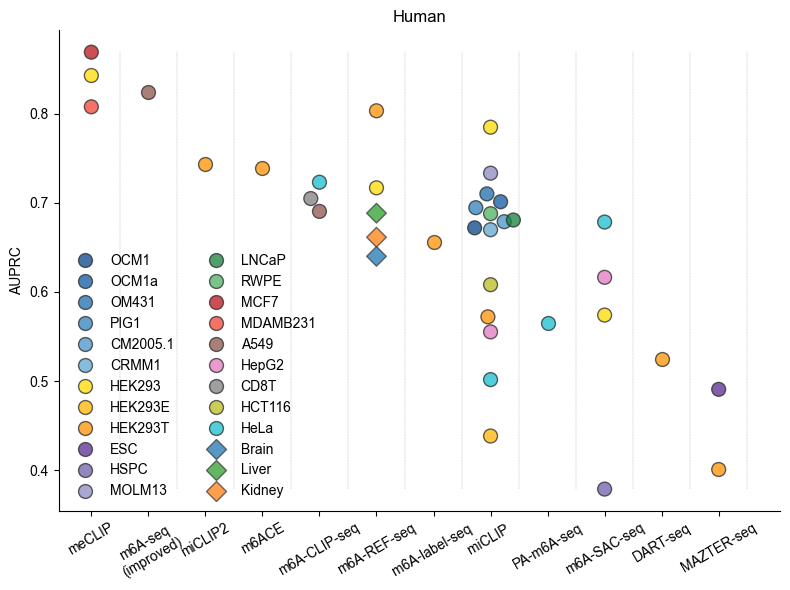

In [16]:
fig = plt.figure(figsize=(8, 6))
ax = fig.subplots()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

order = ['meCLIP', 'm6A-seq\n(improved)', 'miCLIP2', 'm6ACE', 'm6A-CLIP-seq',
       'm6A-REF-seq', 'm6A-label-seq ', 'miCLIP ', 'PA-m6A-seq', 'm6A-SAC-seq',
       'DART-seq', 'MAZTER-seq']
# sns.stripplot(df[~df[0].isin(['Brain', 'Liver', 'Kidney'])], x=1, y=2, hue=0, s=10, alpha=.75, palette=dict(cmaps), jitter=.2, linewidth=1, order=order)
# sns.stripplot(df[df[0].isin(['Brain', 'Liver', 'Kidney'])], x=1, y=2, hue=0, order=order, s=10, alpha=.75, palette='tab10', jitter=.2, linewidth=1, marker='D')
sns.swarmplot(df[~df[0].isin(['Brain', 'Liver', 'Kidney'])], x=1, y=2, hue=0, s=10, alpha=.75, palette=dict(cmaps), linewidth=1, order=order)
sns.swarmplot(df[df[0].isin(['Brain', 'Liver', 'Kidney'])], x=1, y=2, hue=0, order=order, s=10, alpha=.75, palette='tab10', linewidth=1, marker='D')

for idx, i in enumerate(order):
    plt.vlines(idx+0.5, df[2].min(), df[2].max(), linestyles='dashed', color='grey', lw=.2)

plt.ylabel('AUPRC')
plt.xlabel('')
plt.xticks(rotation=30)

handles, labels = plt.gca().get_legend_handles_labels()
should = ['OCM1', 'OCM1a', 'OM431', 'PIG1', 'CM2005.1', 'CRMM1', 'HEK293', 'HEK293E', 'HEK293T', 'ESC', 'HSPC', 'MOLM13', 'LNCaP', 'RWPE', 'MCF7', 'MDAMB231', 'A549', 'HepG2', 'CD8T', 'HCT116', 'HeLa', 'Brain', 'Liver', 'Kidney']
order = [labels.index(i) for i in should]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc='lower left', ncol=2, frameon=False)
plt.title('Human')
plt.tight_layout()
plt.savefig('fig/atlas2_human_prc.svg')
plt.show()

In [17]:
_, cls, _ = utils.load('data/m6aatlas/atlas2_mouse.data')
result = utils.load('data/m6aatlas/atlas2_mouse.metrics')

In [18]:
df = []
for name, i in zip(cls, result):
    name = name.split('_')
    # df += [[name[0], name[1], i[-1]['1.0']['precision']]]
    df += [[name[0], name[1], i[2]]]
df = pd.DataFrame(df).replace({'m6A-seq with improved protocol': 'm6A-seq\n(improved)'})
df = df.replace({'Mouse Embryonic Fibroblasts (MEFs)': 'MEFs', 'dorsal root ganglion?(DRG)': 'DRG', 'macrophages': 'Macrophages'})

In [19]:
df[2].mean()

np.float64(0.658177311538554)

In [20]:
df.to_csv('fig/atlas2_mouse.csv')

In [21]:
df.groupby(1).agg({2: 'mean'}).sort_values(2).index[::-1]

Index(['MAZTER-seq', 'm6A-seq2', 'm6A-seq\n(improved)', 'miCLIP2',
       'm6A-CLIP-seq', 'm6A-REF-seq', 'miCLIP '],
      dtype='object', name=1)

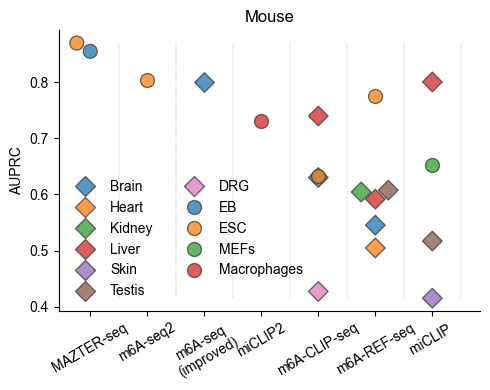

In [22]:
fig = plt.figure(figsize=(5, 4))
ax = fig.subplots()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

order = ['MAZTER-seq', 'm6A-seq2', 'm6A-seq\n(improved)', 'miCLIP2',
       'm6A-CLIP-seq', 'm6A-REF-seq', 'miCLIP ']
# sns.stripplot(df[~df[0].isin(['Brain', 'Liver', 'Kidney', 'Heart', 'Skin', 'Testis'])], x=1, y=2, hue=0, s=10, alpha=.75, palette='tab10', jitter=.1, linewidth=1, order=order)
# sns.stripplot(df[df[0].isin(['Brain', 'Liver', 'Kidney', 'Heart', 'Skin', 'Testis'])], x=1, y=2, hue=0, order=order, s=10, alpha=.75, palette='tab10', jitter=.1, linewidth=1, marker='D')

sns.swarmplot(df[df[0].isin(['Brain', 'Liver', 'Kidney', 'Heart', 'Skin', 'Testis', 'DRG'])], x=1, y=2, hue=0, s=10, alpha=.75, palette='tab10', linewidth=1, order=order, marker='D')
sns.swarmplot(df[~df[0].isin(['Brain', 'Liver', 'Kidney', 'Heart', 'Skin', 'Testis', 'DRG'])], x=1, y=2, hue=0, s=10, alpha=.75, palette='tab10', linewidth=1, order=order)

for idx, i in enumerate(order):
    plt.vlines(idx+0.5, df[2].min(), df[2].max(), linestyles='dashed', color='grey', lw=.2)
    
plt.ylabel('AUPRC')
plt.xlabel('')
plt.xticks(rotation=30)

# handles, labels = plt.gca().get_legend_handles_labels()
# should = ['OCM1', 'OCM1a', 'OM431', 'PIG1', 'CM2005.1', 'CRMM1', 'HEK293', 'HEK293E', 'HEK293T', 'ESC', 'HSPC', 'MOLM13', 'LNCaP', 'RWPE', 'MCF7', 'MDAMB231', 'A549', 'HepG2', 'CD8T', 'HCT116', 'HeLa', 'Brain', 'Liver', 'Kidney']
# order = [labels.index(i) for i in should]
# plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], bbox_to_anchor=(1, 1), loc=2)
# plt.legend(bbox_to_anchor=(1, 1), loc=2)
plt.legend(loc='lower left', ncol=2, frameon=False)
plt.title('Mouse')
plt.tight_layout()
plt.savefig('fig/atlas2_mouse_prc.svg')
plt.show()

In [23]:
_, cls, _ = utils.load('data/m6aatlas/atlas2_rat.data')
result = utils.load('data/m6aatlas/atlas2_rat.metrics')

In [24]:
df = []
for name, i in zip(cls, result):
    name = name.split('_')
    # df += [[name[0], name[1], i[-1]['1.0']['precision']]]
    df += [[name[0], name[1], i[2]]]
df = pd.DataFrame(df).replace({'m6A-seq with improved protocol': 'm6A-seq\n(improved)'})
df = df.replace({'Mouse Embryonic Fibroblasts (MEFs)': 'MEFs', 'dorsal root ganglion?(DRG)': 'DRG', 'macrophages': 'Macrophages'})

In [25]:
df#[2].mean()

,0,1,2
0,Brain,m6A-REF-seq,0.645015
1,Kidney,m6A-REF-seq,0.602383
2,Liver,m6A-REF-seq,0.625162


In [26]:
df.to_csv('fig/atlas2_rat.csv')

In [27]:
df.groupby(1).agg({2: 'mean'}).sort_values(2).index[::-1]

Index(['m6A-REF-seq'], dtype='object', name=1)

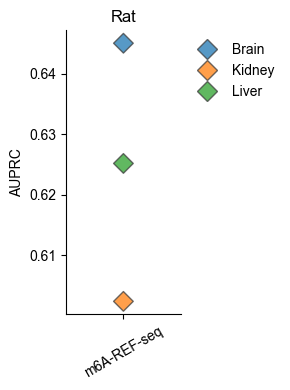

In [28]:
fig = plt.figure(figsize=(3, 4))
ax = fig.subplots()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

order = ['m6A-REF-seq']
sns.swarmplot(df, x=1, y=2, hue=0, s=10, alpha=.75, palette='tab10', linewidth=1, order=order, marker='D')

plt.ylabel('AUPRC')
plt.xlabel('')
plt.xticks(rotation=30)

# handles, labels = plt.gca().get_legend_handles_labels()
# should = ['OCM1', 'OCM1a', 'OM431', 'PIG1', 'CM2005.1', 'CRMM1', 'HEK293', 'HEK293E', 'HEK293T', 'ESC', 'HSPC', 'MOLM13', 'LNCaP', 'RWPE', 'MCF7', 'MDAMB231', 'A549', 'HepG2', 'CD8T', 'HCT116', 'HeLa', 'Brain', 'Liver', 'Kidney']
# order = [labels.index(i) for i in should]
# plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], bbox_to_anchor=(1, 1), loc=2)
# plt.legend(bbox_to_anchor=(1, 1), loc=2)
plt.legend(bbox_to_anchor=(1, 1), loc=2, frameon=False)
plt.title('Rat')
plt.tight_layout()
plt.savefig('fig/atlas2_rat_prc.svg')
plt.show()

## Performance

In [29]:
_, cls, _ = utils.load('data/m6aatlas/atlas2_human.data')
whistle = utils.load('whistle/model/atlas2.metrics')
whistle = dict(whistle)

In [32]:
result = []
for j in cls:
    key = f'data/{j.replace(' ', '.')}_whistle.bed.hg19.bed.out.csv'
    k = whistle[key]
    j = j.split('_')
    result += [('human', 'WHISTLE', j[0], j[1], k[2])]

for method in ['single', 'dp']:
    for i in ['human', 'mouse', 'rat']:
        _, cls, _ = utils.load(f'data/m6aatlas/atlas2_{i}.data')
        test_res = utils.load(f'model/atlas2_{i}_full_400_ythdf_{method}.metrics')
        for j, k in zip(cls, test_res):
            j = j.split('_')
            result += [(i, method, j[0], j[1], k[2])]

for i in ['human', 'mouse', 'rat']:
    _, cls, _ = utils.load(f'data/m6aatlas/atlas2_{i}.data')
    r = utils.load(f'data/m6aatlas/atlas2_{i}.metrics')
    for j, k in zip(cls, r):
        j = j.split('_')
        result += [(i, 'deepSRAMP', j[0], j[1], k[2])]


In [33]:
pd.DataFrame(result).replace({
    'human': 'Human', 
    'mouse': 'Mouse',
    'rat': 'Rat',
    'dp': 'DeepPromise',
    'single': 'deepSRAMP_single',
}).set_index([0, 2, 3, 1]).unstack()[4][['deepSRAMP', 'deepSRAMP_single', 'WHISTLE', 'DeepPromise']].to_csv('fig/atlas2_performance.csv')